# Assessing Spatial Patterns of Agricultural Pesticide Use and Risks to Pollinator Populations

__Published: 12/06/2024__

## Introduction

In spite of scarce time-series data on pollinator populations, it is evident that globally, both wild and domesticated pollinator populations are in decline [1, 2]. This is the case even in relatively undisturbed ecosystems, perhaps a result of changing climate patterns and the arrival of invasive species [3].

Pesticide use for agriculture poses a more direct, and significant threat to pollinator populations, prompting EU restrictions on the use of certain pesticide groups - for instance neonicotinoids - in recent years (the Commission aims to reduce general pesticide use by 50% by 2030) [1]. 

Given the importance of pollinators to our food systems (more than 80% of agricultural crops depend on insect pollination to some extent [4]), there is a strong case to be made for adapting those systems to function in ways that do not adversely affect the pollinator populations on which they depend. 

In place of a full pesticide ban, which remains unrealistic as a global short-term solution, optimisation of pesticide use, local regulations, and conservation efforts represents a more realistic and potentially effective approach.


__Objectives__<br>
This notebook aims to highlight areas in the UK in which agricultural yields are relatively low and pesticide inputs are relatively high. In the context of a pollinator abundance species distribution model, I show how this operations data presents an opportunity to optimise large-scale sustainable farming strategies to maintain productivity whilst reducing pesticide exposure for pollinators. Such a methodology could, for instance, be used to aid conservation or agricultural policy decision-making. 

Two datasets are used here: UK Pollinator Monitoring Scheme (PoMS) data and UK CEH pesticide to agricultural yield ratio maps. 

Specific objectives are as follows:
1. Build a pollinator abundance-based species distribution model (SDM) using UK PoMS data.
2. Investigate the pesticide hazard to agricultural yield map, which itself is of practical value.
3. Combine the datasets from objectives (1.) and (2.) to identify areas in which a high abundance of pollinators and a high pesticide to agricultural yield ratio are simultaneously observed.




## Imports

In [1]:
# Vector processing
import geopandas as gpd
import shapely
import osgb

# Raster processing
import rasterio
import rasterio.warp
import rasterio.mask
import rasterio.plot
import rasterio.features
import rasterio.sample
import rasterio.fill
from rasterio import windows
import pyproj
import xarray as xr
import rioxarray

# Calcs and modelling
import numpy as np
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score, GroupKFold
from sklearn import model_selection, svm
import elapid as ela

# Visualisation
import matplotlib as mpl
from matplotlib import pyplot as plt
import contextily as cx
import seaborn as sns
import geoplot as gplt

# Practical
from glob import glob
import warnings
import os
from pystac_client import Client
import boto3
from dask.distributed import Client as DaskClient, print as distributed_print
import subprocess
import functools
import sys
sys.path.append('../../../../git_packages/PhenoloPy/scripts')
import phenolopy
from scipy.stats import pearsonr, zscore
from tqdm import tqdm
from ast import literal_eval

%matplotlib inline

mpl.rcParams['axes.formatter.limits'] = (0, 0)
FIGSIZE = (10, 7)

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

DATA_BASE_PATH = '../../../data/Agric_data/' # all data under this path (global)

# Here use the CRS of the UK CEH pesticide maps
WORKING_CRS = 'EPSG:27700'

## Methods

### Biodiversity data: UK PoMS Fit Counts

The UK PoMS flower-insect timed count dataset [5], provides pollinator abundance observations collected by volunteers at locations across the UK. Insect counts, split by broad taxon groups, are recorded for 50cm x 50cm quadrats on 10 minute periods, for a given target plant.

Here the dataset is loaded and cleaned. The cleaned dataset consists of 2578 samples taken between 2017 and 2020 (inclusive).

Expand the cell to see the code.

In [2]:
# Read in data
sample_data = gpd.read_file(os.path.join(DATA_BASE_PATH, 'Pollinator_Fit_Counts/data/ukpoms_publicfitcountdata_2017-2020.csv' ), encoding='unicode_escape')

# Type conversions
sample_data[['honeybees', 'floral_unit_count']] = sample_data[['honeybees', 'floral_unit_count']].astype(int)
sample_data['month'] = sample_data['date'].str.split('/').str[1]

# Filter to England for comparison to UK CEH pesticide maps
sample_data = sample_data[sample_data['country'] == 'England']

# Some wrangling of geodata ->  transform to working spatial reference system
def parse_grid_handle_error(x1km_ref):
    try:
        return osgb.gridder.parse_grid(x1km_ref)
        
    except:
        return None

def grid_to_ll_handle_error(grid_ref):
    try:
        return osgb.grid_to_ll(grid_ref)

    except:
        return (np.nan, np.nan)

sample_data['X1km_centre'] = sample_data['X1km_square'].str[:4].str.cat(sample_data['X1km_square'].str[4:], sep='5') + '5'
sample_data['geometry'] = sample_data['X1km_centre'].apply(parse_grid_handle_error).apply(grid_to_ll_handle_error).apply(lambda x: (x[1], x[0])).apply(shapely.geometry.Point)
sample_data = sample_data[~sample_data['geometry'].is_empty]
sample_data.set_crs('EPSG:4326', inplace=True).to_crs(WORKING_CRS, inplace=True)

# Show the dataset
sample_data.head()

sample_id  country        date  year X1km_square sample_projection  \
0   3501506  England  05/05/2018  2018      SK3648              OSGB   
1   3493125  England  05/05/2018  2018      SK9482              OSGB   
2   3455170  England  05/05/2018  2018      SP0380              OSGB   
3   3455025  England  05/05/2018  2018      ST3109              OSGB   
4   3501609  England  19/05/2018  2018      SK3648              OSGB   

  digitised_by                                      recorder_type  \
0        86644  I am familiar with recognising the main groups...   
1       154133  I am familiar with identifying some wildlife g...   
2        73313  I am familiar with recognising the main groups...   
3       156295  I am familiar with recognising the main groups...   
4        86644  I am familiar with recognising the main groups...   

                                     habitat habitat_other_detail  \
0                                     Garden                   NA   
1                                     Garden                   NA   
2                                     Garden                   NA   
3  Grassland with wild flowers (e.g. meadow)                   NA   
4                                     Garden                   NA   

                      target_flower           target_flower_corrected  \
0  Dandelion - Taraxacum officinale  Dandelion - Taraxacum officinale   
1              Hawthorn - Crataegus              Hawthorn - Crataegus   
2     Other - please describe below     Other - please describe below   
3    Buttercup (Ranunculus species)    Buttercup (Ranunculus species)   
4  Dandelion - Taraxacum officinale  Dandelion - Taraxacum officinale   

  target_other_name target_other_name_corrected target_flower_family  \
0                NA                          NA           Asteraceae   
1                NA                          NA             Rosaceae   
2        Pulmonaria                  Pulmonaria         Boraginaceae   
3                NA                          NA        Ranunculaceae   
4                NA                          NA           Asteraceae   

                                   flower_cover  floral_unit_count  \
0  Target flowers cover less than half of patch                  6   
1      Target flowers cover about half of patch                 22   
2      Target flowers cover about half of patch                 15   
3  Target flowers cover less than half of patch                 10   
4  Target flowers cover less than half of patch                  1   

         floral_unit                                     flower_context  \
0        flower head       Growing in a larger patch of the same flower   
1  individual flower       Growing in a larger patch of the same flower   
2  individual flower  Growing in a larger patch of many different fl...   
3  individual flower       Growing in a larger patch of the same flower   
4        flower head                              More or less isolated   

  count_start_time               cloud_cover                         sunshine  \
0            11:55        All or mostly blue             Entirely in sunshine   
1            15:01        All or mostly blue             Entirely in sunshine   
2            15:47        All or mostly blue  Partly in sun and partly shaded   
3            14:36  Half blue and half cloud             Entirely in sunshine   
4            12:18  Half blue and half cloud             Entirely in sunshine   

                          wind_speed    enjoyment difficulty  habitat_type  \
0  Leaves moving gently all the time          Fun  Very easy        garden   
1  Leaves moving gently all the time  Really fun!       Okay        garden   
2   Leaves still/moving occasionally         Okay       Easy        garden   
3  Leaves moving gently all the time           NA         NA  semi-natural   
4   Leaves still/moving occasionally          Fun  Very easy        garden   

  flower_structure bumblebees  honeybee

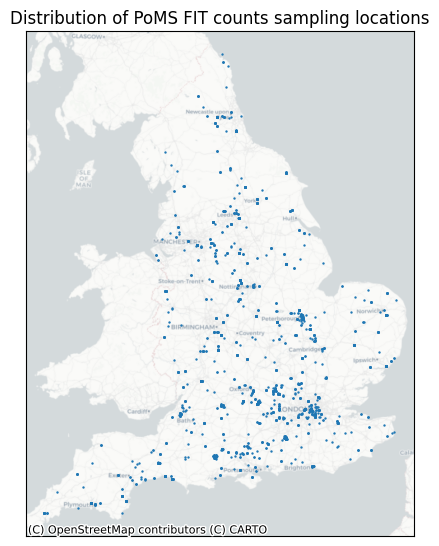

In [45]:

fig, ax = plt.subplots(figsize=(5, 8))

sample_data.plot(ax=ax, markersize=0.5)

cx.add_basemap(ax, crs=sample_data.crs, source=cx.providers.CartoDB.Positron)

plt.title('Distribution of PoMS FIT counts sampling locations')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

### Honey bee species distribution model (abundance)

The pesticide loading maps investigated in the next section use toxicity weightings for honeybees (Apis mellifera) specifically. Therefore, PoMS observations for honeybees are taken as the basis for the SDM fitting process presented here.

A recent systematic review of abundance-based SDMs [6] suggests that random forests perform best amongst 24 model frameworks investigated.

The SDM approach presented in the previous article "Species Distribution Modelling with Python" is applied again here using random forests (with a variety of parameters tested), taking into account specific recommendations from that abundance SDM review. Worldclim climate variables [7] were used, as well as SRTM elevation data.

#### Load and prep features

Because sampling locations are given on a kilometre square grid, multiple samples are grouped within each "location" in the PoMS dataset. An inverse frequency weighting is used to ensure that this does not bias the SDM (though spatial biases at a larger scale would persist).

In [23]:
# There are many duplicate sampling locations (X1 squares) with different surveying metadata
# Weight samples at the same location such that each location essentially counts for one
count_map = sample_data.groupby('X1km_square', group_keys=False)['sample_id'].count().to_dict()
sample_data['loc_dupl_count'] = sample_data['X1km_square'].map(lambda x: count_map.get(x, pd.NA))
sample_data['sample_weight'] = 1 / sample_data['loc_dupl_count']

Now evalute bioclimatic variables at all locations sampled in the PoMS dataset.

Expand the cell to see the code.

In [ ]:
# Bio var mappings
bio_vars = {
    'bio_19': 'precipitation of coldest quarter', 
    'bio_18': 'precipitation of warmest quarter',
    'bio_17': 'precipitation of driest quarter',
    'bio_16': 'precipitation of wettest quarter',
    'bio_15': 'precipitation seasonality (coefficient   of   variation)',
    'bio_14': 'precipitation of driest period',
    'bio_13': 'precipitation of wettest period',
    'bio_12': 'annual precipitation',
    'bio_11': 'precipitation of coldest quarter',
    'bio_10': 'precipitation of warmest quarter',
    'bio_9': 'mean temperature of driest quarter',
    'bio_8': 'mean temperature  of  wettest  quarter',
    'bio_7': 'temperature annual range',
    'bio_6': 'minimum temperature of coldest period',
    'bio_5': 'maximum temperature of warmest period',
    'bio_4': 'temperature season-ality  (coefficient  of  variation)',
    'bio_3': 'isothermality',
    'bio_2': 'mean diurnal range',
    'bio_1':  'annual mean temperature',
    'elev': 'SRTM elevation'
}


# Define unique locations
loc_index = sample_data.drop_duplicates(subset='X1km_square').index
loc_coords = np.vstack([sample_data.loc[loc_index, 'geometry'].x, sample_data.loc[loc_index, 'geometry'].y]).T

# For each biovar get its value at the PoMS record locations
bio_samples = {}
bio_var_paths = []
for bio_var in bio_vars:
    path = glob('../../../data/SDM_data/covar/epsg_27700/*' + bio_var + '_England*.tif', recursive=False)[0]
    bio_var_paths.append(path)
    with rasterio.open(path) as rio_ds:
        bio_samples[bio_var] = np.array(list(rasterio.sample.sample_gen(rio_ds, 
                                                                          loc_coords, 
                                                                          indexes=1, 
                                                                          masked=False))).flatten() 
        nodata_val, ref_shape, ref_bounds, ref_profile = rio_ds.nodata, rio_ds.shape, rio_ds.bounds, rio_ds.profile

# Clean no_data values 
bio_sample_df = pd.DataFrame(bio_samples, index=loc_index)
bio_sample_df = bio_sample_df[~(bio_sample_df == nodata_val).any(axis=1)]

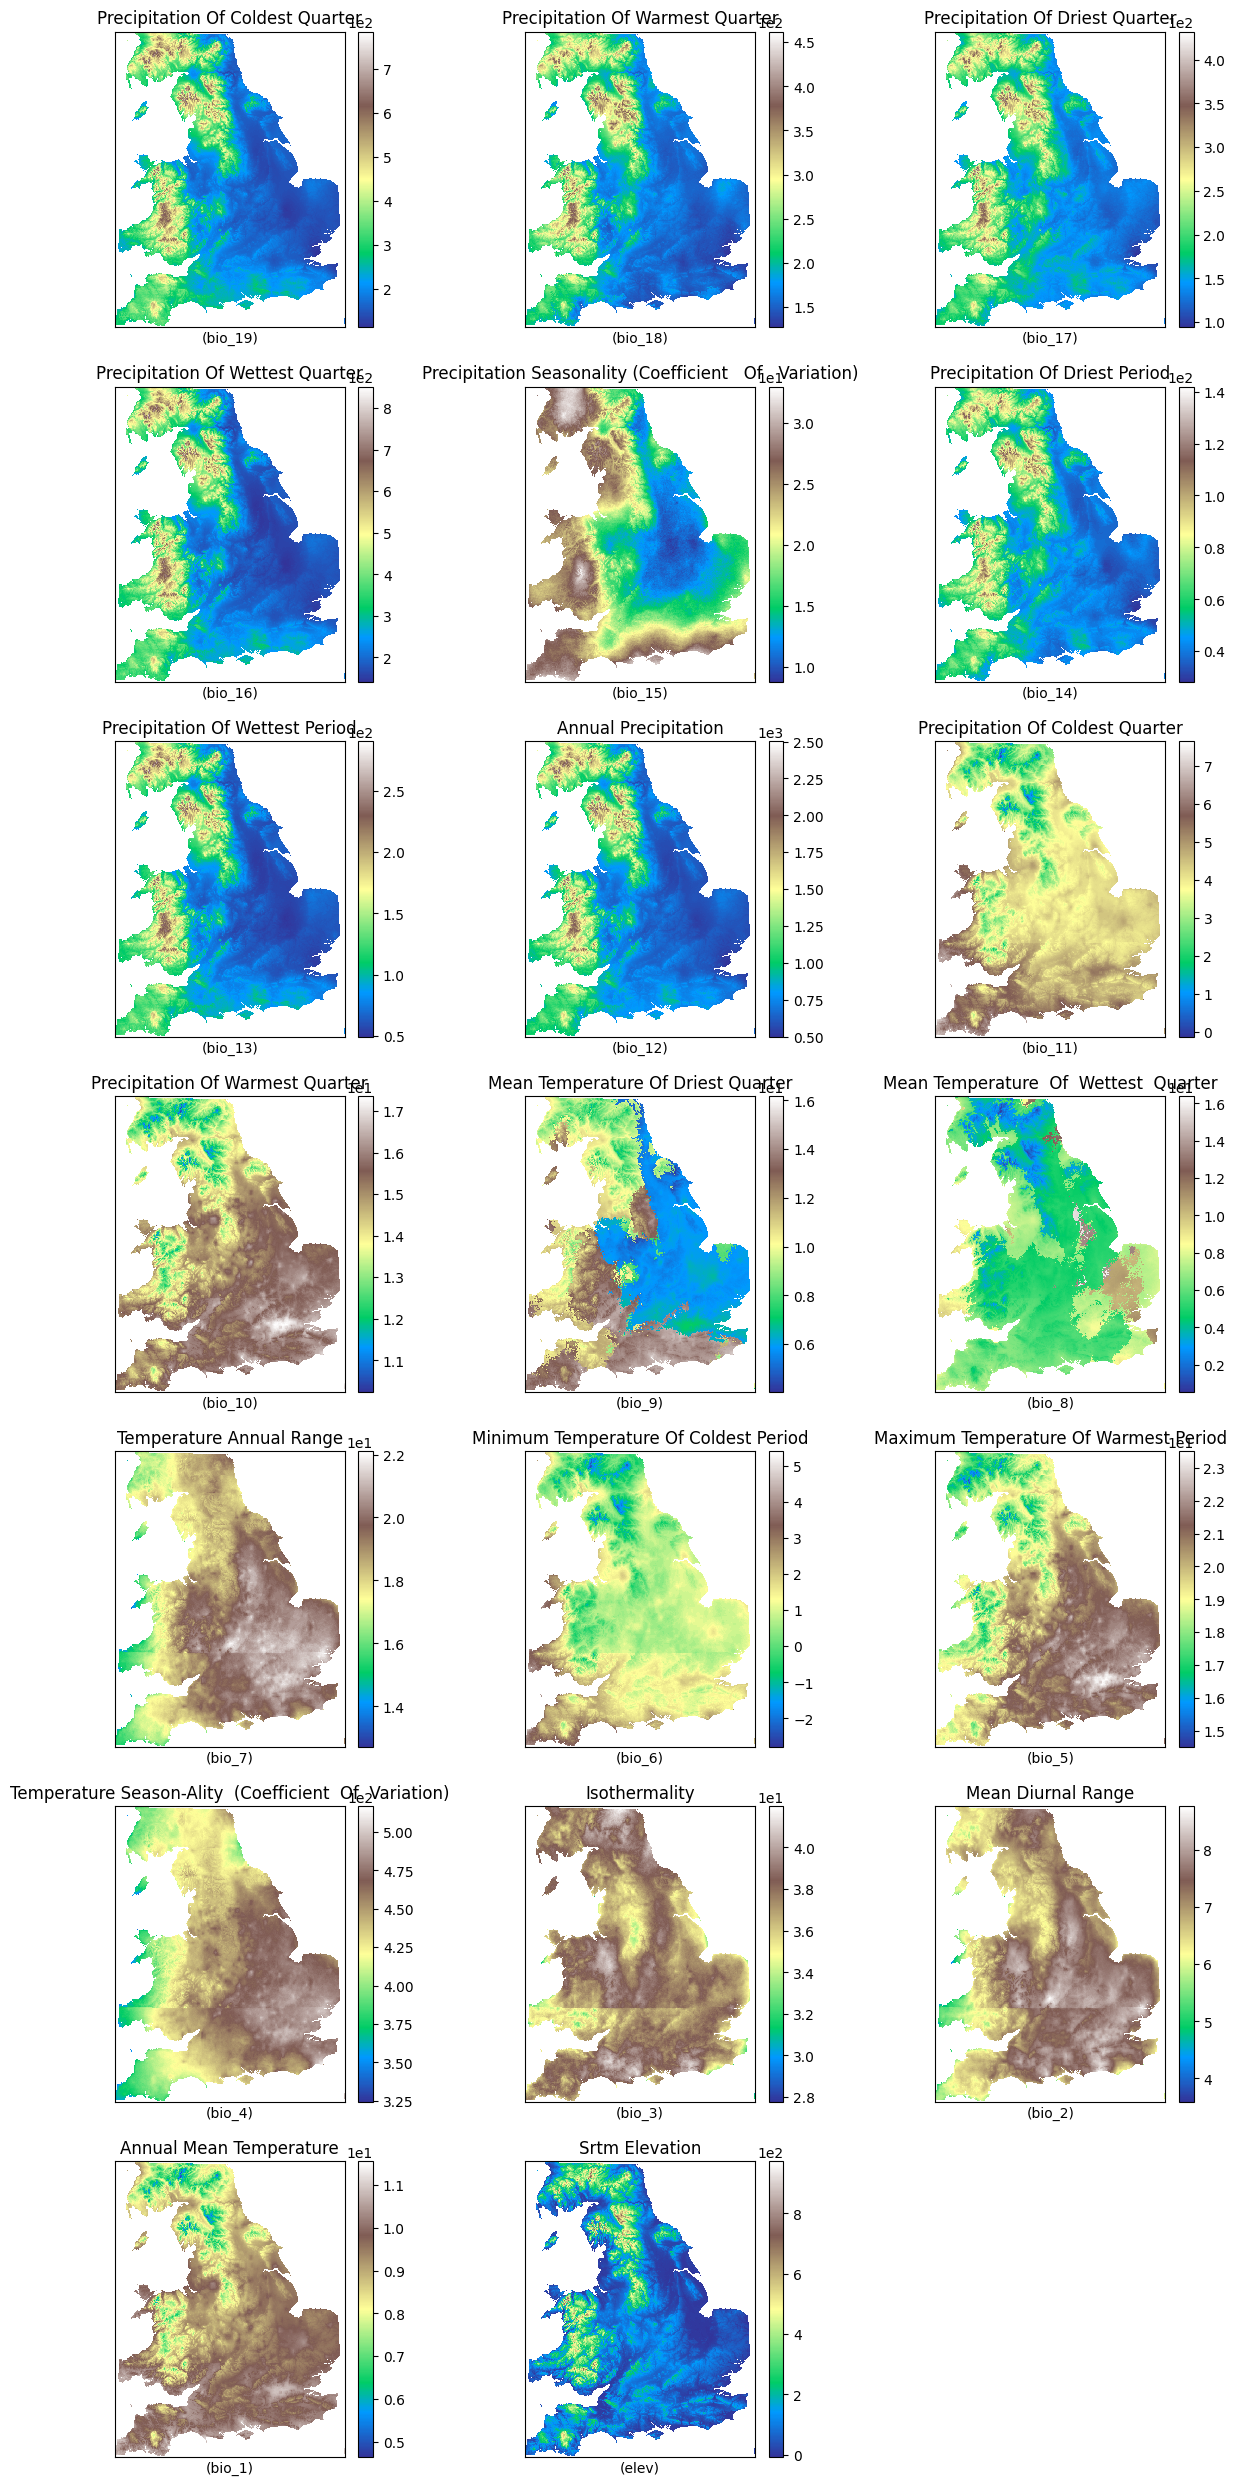

In [192]:
fig, axs = plt.subplots( nrows=7, ncols=3, figsize=(FIGSIZE[0]*3/2, FIGSIZE[1]*9/2))

for fp, name, ax in zip(bio_var_paths, bio_vars, axs.ravel()):
    with rasterio.open(fp) as file:
        output=file.read(1)
        mask=file.read_masks(1)

    im = ax.imshow(np.where(mask == 0, np.nan, output), 
                   cmap='terrain', 
                   extent = [ref_bounds.left, ref_bounds.right, ref_bounds.bottom, ref_bounds.top],
                   interpolation='nearest', # Just for image / display resolution mismatches, does not alter underlying values
                  )
    
    # occ_data.plot(ax=ax, markersize=5, color='k', marker='^', label='Occurrence records')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(0.5, -0.05, f'({name})', horizontalalignment='center', transform=ax.transAxes)
    fig.colorbar(im, label=None, fraction=0.046, pad=0.04)
    ax.set_title(bio_vars[name].title(), wrap=True)

axs[-1, -1].set_axis_off()
# fig.tight_layout()
plt.show()

As noted in the post on "Species Distribution Modelling with Python", some worldclim layers suffer from discontinuities, which are visible above. Dropping those with major discontinuities:

In [26]:
to_drop = ['bio_2', 'bio_3', 'bio_4', 'bio_6', 'bio_7'] 

bio_sample_df.drop(columns=to_drop, inplace=True)
[bio_vars.pop(k) for k in to_drop]

['mean diurnal range',
 'isothermality',
 'temperature season-ality  (coefficient  of  variation)',
 'minimum temperature of coldest period',
 'temperature annual range']

Now analysing correlations and removing highly correlated features, as in "Species Distribution Modelling with Python":

In [27]:
bio_sample_df_norm = bio_sample_df.apply(zscore)
base_pca = sklearn.decomposition.PCA(n_components=3)
base_pca.fit_transform(bio_sample_df_norm)

print('Percentage of variance explained by PC1, PC2 and PC3 respectively:')
print(base_pca.explained_variance_ratio_)

Percentage of variance explained by PC1, PC2 and PC3 respectively:
[0.5847062  0.22729    0.06444322]


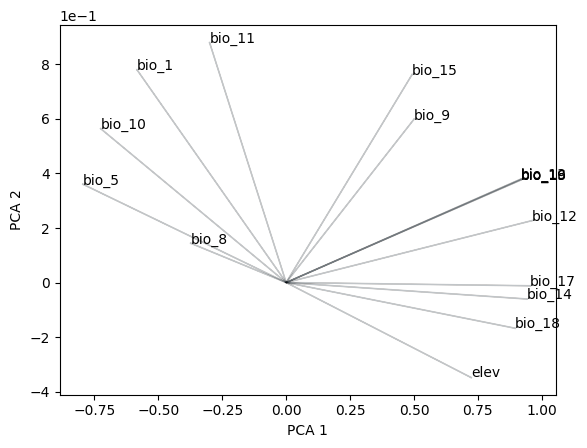

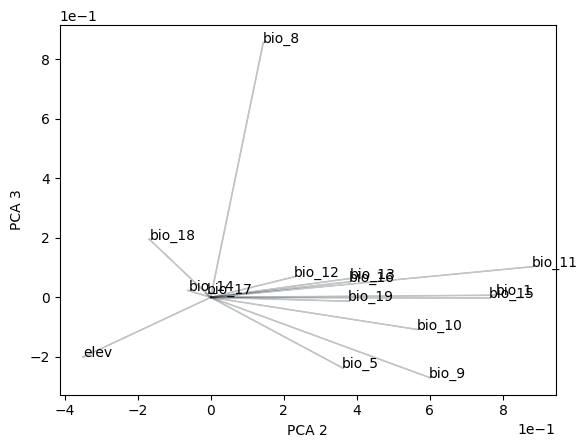

In [10]:
for pc_pair in [[1, 2], [2, 3]]: #, [1, 3]]:
    plt.figure()
    ax = plt.gca()
    for (x, y), label in zip(base_pca.components_.T[:, [pc_pair[0] - 1, pc_pair[1] -1]] * np.sqrt(base_pca.explained_variance_[[pc_pair[0] - 1, pc_pair[1] -1]]), 
                             bio_sample_df_norm.columns):
        plt.arrow(0, 0, x, y, alpha=0.2)
        plt.text(x, y, label)
    
    plt.xlabel('PCA {}'.format(pc_pair[0]))
    plt.ylabel('PCA {}'.format(pc_pair[1]))
    plt.show()

In [28]:
corr_matrix = bio_sample_df.corr(method='spearman')

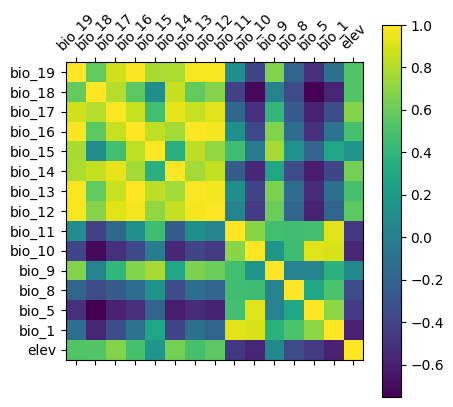

In [319]:
tick_pos = np.array(range(len(corr_matrix)))
plt.matshow(corr_matrix)
plt.xticks(tick_pos, corr_matrix.columns.values, rotation=45)
plt.yticks(tick_pos, corr_matrix.index.values)
plt.colorbar()
plt.show()

And the pairwise correlations above a threshold (here set to 0.8):

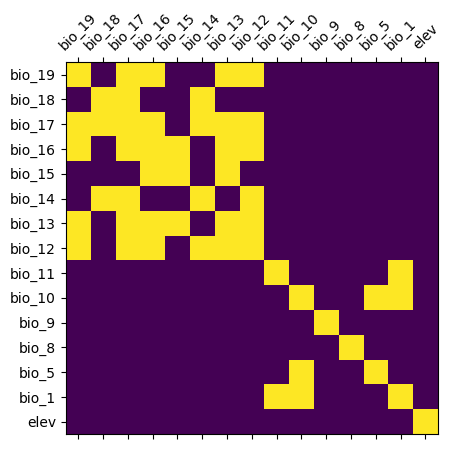

In [29]:
tick_pos = np.array(range(len(corr_matrix)))
plt.matshow(corr_matrix > 0.8)
plt.xticks(tick_pos, corr_matrix.columns.values, rotation=45)
plt.yticks(tick_pos, corr_matrix.index.values)
plt.show()

Identify pairwise correlated covariates, and each covariate's score - here the norm of the PCA loadings  (later used to select amongst covariates).

In [34]:
corr_pairs = (corr_matrix.abs() > 0.8).unstack()[np.triu(np.ones(corr_matrix.shape)).astype('bool').reshape(corr_matrix.size)]
corr_pairs = [pair for pair in corr_pairs[corr_pairs].index.values if pair[0] != pair[1]]

covar_contributions = dict(zip(bio_sample_df_norm.columns.to_list(), 
                               np.linalg.norm(base_pca.components_.T * np.sqrt(base_pca.explained_variance_), # eigenvectors scaled by sqrt(eigenvalues)
                                              axis=1)))

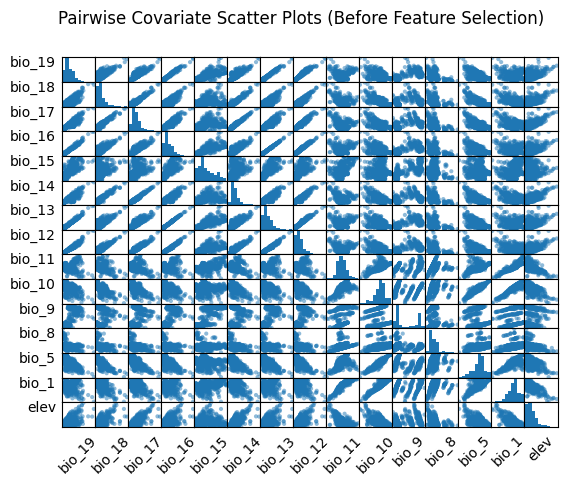

In [267]:
axs = pd.plotting.scatter_matrix(bio_sample_df)
for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.xaxis.label.set_rotation(45)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
plt.suptitle('Pairwise Covariate Scatter Plots (Before Feature Selection)')
plt.show()

It is very often the case that more features are removed than required when pairwise correlated features are sequentially dropped. For instance, say we have some method of sorting features by preference (e.g. by information content, explained variance etc.) which allows us to choose which feature to keep and which to remove when considering a pair of correlated features. If we simply iterate through all of the pairwise correlated features, and drop either the pair, or in each pair the feature with the lower score, we drop more features than necessary. That is because each time a feature is removed from the model (dropped), correlated feature pairings that previously included that dropped feature no longer represent redundancies.

The algorithm below takes into account this consideration, building on the approach presented in the earlier post on "Species Distribution Modelling with Python", to retain a maximal number of uncorrelated features for the subsequent modelling process.

Expand the cell to see the code.

In [ ]:
def get_sorted_corr_covars(corr_pairs, covar_contributions):
    ''' takes a set of corr pairs and returns the list of unique covars, sorted in order of most to least variance explained '''
    return sorted(list(set([j for i in corr_pairs for j in i])), key=lambda x: -covar_contributions[x])

def remove_pop_rows(corr_pairs, covar):
    '''for each row in which covar appears in corr_pairs, delete the row and set aside the paired covar into a list, which is returned at the end'''
    paired = []
    cleaned_corr_pairs = []
    for row in corr_pairs:
        if covar in row:
            pair = [i for i in row if i != covar][0]
            paired.append(pair)
        else:
            cleaned_corr_pairs.append(row)

    return cleaned_corr_pairs, paired

# Now loop through the list of  all the correlated covar pairs, keeping the "best" covar each time
# Initialise
to_keep = [i for i in bio_sample_df.columns if i not in get_sorted_corr_covars(corr_pairs, covar_contributions)] # initilaise with those features that are not colinear
while len(corr_pairs) > 0:
    # Get best covar remaining and add it to the keep list
    best_covar = get_sorted_corr_covars(corr_pairs, covar_contributions)[0]
    if best_covar not in to_keep:
        to_keep.append(best_covar)

    # Now modify the list of pairwise correlated covars accordingly: first delete rows where that covar appears, but keep track of which covars were in those rows (beaten)
    corr_pairs, beaten = remove_pop_rows(corr_pairs, best_covar)
    
    # for each of those beaten covars,  remove from the pool of covars to keep because beaten covars by definition are not kept in the model
    to_keep = [i for i in to_keep if i not in beaten] # required because keepers could contain now beaten covars from previous loop iters
    
    # delete all rows in which beaten covars appear, recording which covars were paired with them (these are potentially no longer correlated), unless those covars are in the beaten set 
    for covar_beaten in beaten:
        corr_pairs, new_keepers = remove_pop_rows(corr_pairs, covar_beaten)
        to_keep = to_keep + [i for i in new_keepers if (i not in to_keep) and (i not in beaten)]
        

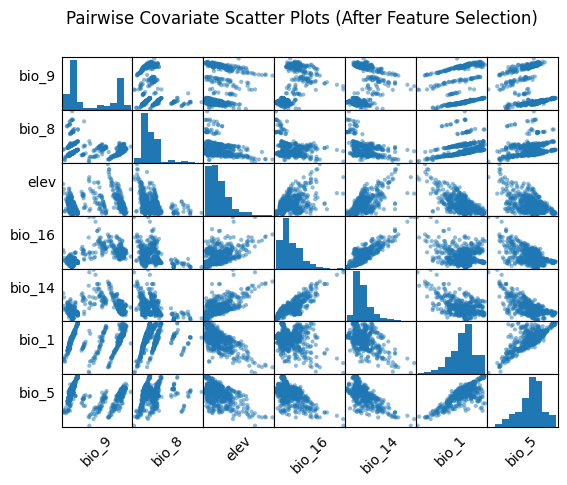

In [39]:
axs = pd.plotting.scatter_matrix(bio_sample_df.loc[:, to_keep])
for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.xaxis.label.set_rotation(45)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
plt.suptitle('Pairwise Covariate Scatter Plots (After Feature Selection)')
plt.show()

In [37]:
bio_sample_df = bio_sample_df.loc[:, to_keep]
bio_vars = {i:bio_vars[i] for i in bio_vars if i in to_keep}

Just verify that the correlated features have indeed been removed:

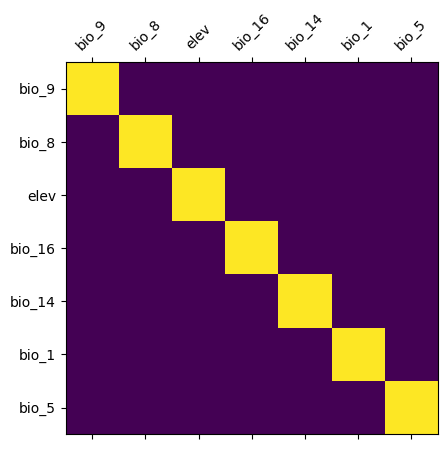

In [38]:
corr_matrix = bio_sample_df.corr(method='spearman')
tick_pos = np.array(range(len(corr_matrix)))
plt.matshow(corr_matrix > 0.8)
plt.xticks(tick_pos, corr_matrix.columns.values, rotation=45)
plt.yticks(tick_pos, corr_matrix.index.values)
plt.show()

In [ ]:
bio_var_paths = [i for i in bio_var_paths if i.split('/')[-1].split('_')[-2] in [i.split('_')[-1] for i in bio_vars]]
bio_sample_df = bio_sample_df.join(sample_data[['X1km_square']]).merge(sample_data.reset_index()[['index', 'X1km_square', 'honeybees', 'sample_weight']], how='outer', on='X1km_square').dropna() # dropna for those locations where the climate covar is undefined (there are only 10 such locations)

#### Build RF model

Now build a random forest model to capture honeybee abundance information. The model built with positive observations only (no absence / pseudo-absence data) is used in [6], so remove zeros from the biodiversity data:

In [48]:
filtered_bio_sample_df = bio_sample_df[(bio_sample_df['honeybees'] > 0)]

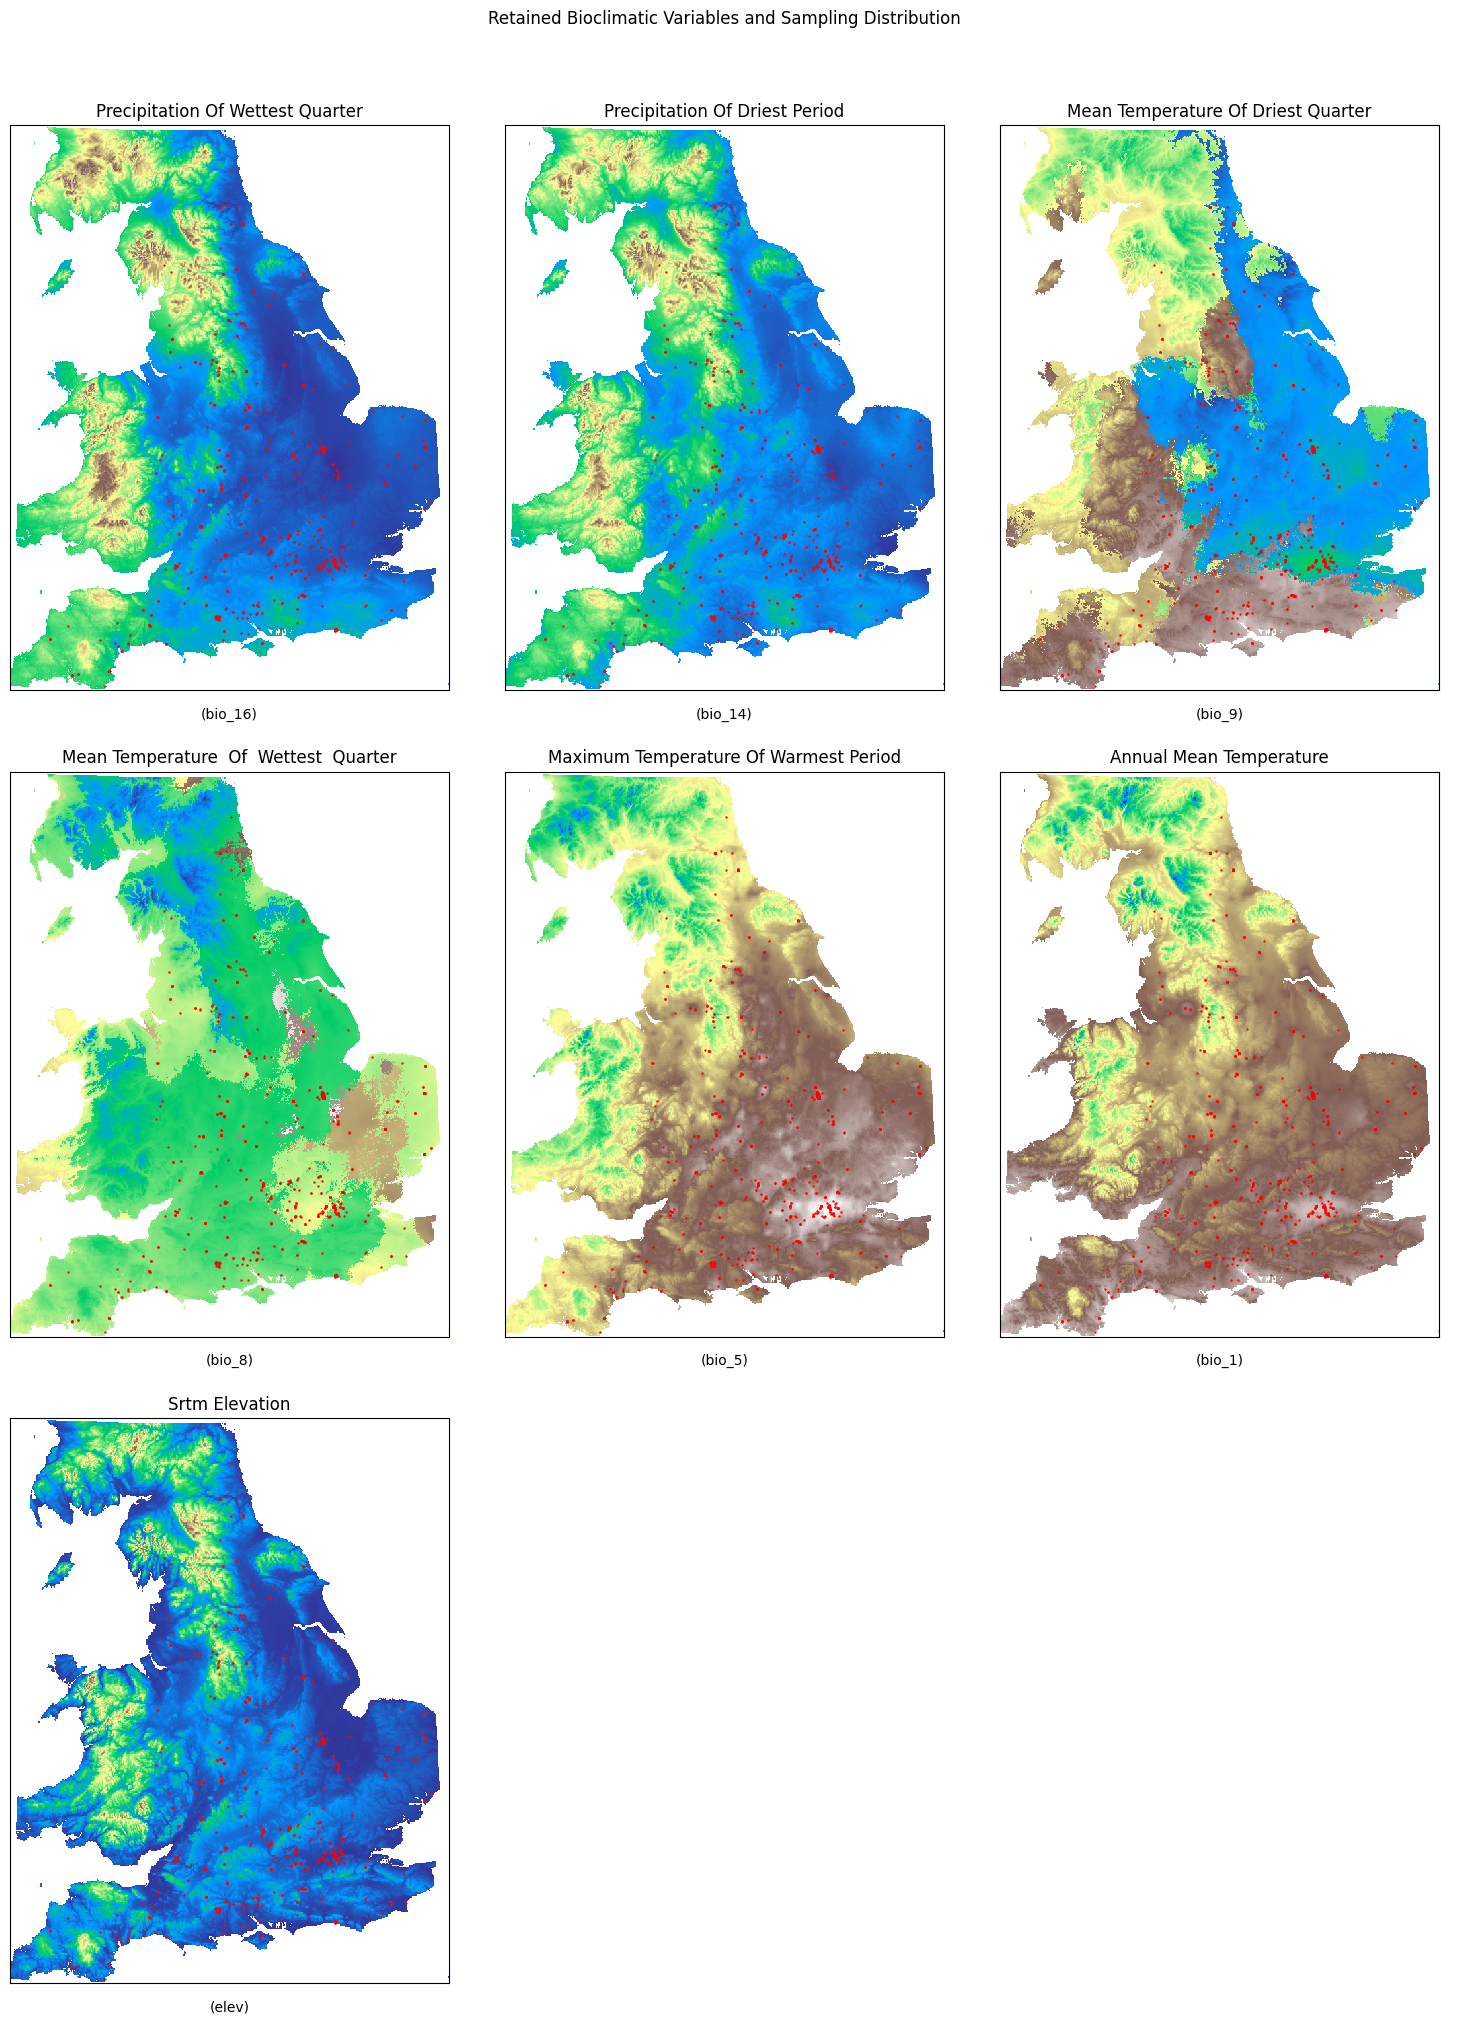

In [49]:
fig, axs = plt.subplots( nrows=3, ncols=3, figsize=(FIGSIZE[0]*3/2, FIGSIZE[1]*6/2), sharex=True, sharey=True)
plt.suptitle('Retained Bioclimatic Variables and Sampling Distribution')
for fp, name, ax in zip(bio_var_paths, bio_vars, axs.ravel()):
    with rasterio.open(fp) as file:
        output=file.read(1)
        mask=file.read_masks(1)

    im = ax.imshow(np.where(mask == 0, np.nan, output), 
                   cmap='terrain', 
                   extent = [ref_bounds.left, ref_bounds.right, ref_bounds.bottom, ref_bounds.top],
                   interpolation='nearest', # Just for image / display resolution mismatches, does not alter underlying values
                  )
    
    sample_data.loc[filtered_bio_sample_df['index'], :].sort_values('honeybees').plot(ax=ax, column='honeybees', color='red', markersize=0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(0.5, -0.05, f'({name})', horizontalalignment='center', transform=ax.transAxes)
    # fig.colorbar(im, label=None, fraction=0.046, pad=0.04)
    ax.set_title(bio_vars[name].title(), wrap=True)

axs[-1, -1].set_axis_off()
axs[-1, -2].set_axis_off()
fig.tight_layout(rect=[0, 0.03, 1, 0.95], h_pad=5)

plt.show()

Now set up an sklearn RF model with log link:

In [93]:
##### Set up test, train features and targets #####
X = filtered_bio_sample_df[['bio_9',	'bio_8',	'elev',	'bio_16',	'bio_14',	'bio_1',	'bio_5']]
y = filtered_bio_sample_df[['honeybees']].rename(columns={'honeybees': 'target'})

# Normalization
X_mean = X.mean()
X_std = X.std()

full_range = np.ones(ref_shape, dtype=bool)

def norm_covs(cov, i):
    return cov
    # return (cov - X_mean[i]) / X_std[i]

X_norm = (X - X_mean) / X_std 

Cross validate grid search on hyperparameters, with an error metric as used in [6]:

In [465]:
def scaled_mean_abs_error(estimator, X, y):
    '''Custom error metric'''
    _y = y.values.reshape(-1)
    predictions = estimator.predict(X)
    absolute_error = np.abs(predictions - _y) / _y

    return np.mean(absolute_error)
    
min_samples_split_set = [2, 5, 20]
max_depth_set = [5, 20, 50]
n_estimators_set = [10, 100, 500]

scores = []
max_depths = []
min_samples_splits = []
n_estimatorss = []

for n_estimators in n_estimators_set:
    print('Beginning n_estimators: ' + str(n_estimators))
    for max_depth in max_depth_set:
        for min_samples_split in min_samples_split_set:
            rf = RandomForestRegressor(n_estimators=n_estimators,
                                       max_depth=max_depth,
                                       min_samples_split=min_samples_split,
                                       random_state=0)

            cv_score = np.mean(cross_val_score(rf, X, y, 
                                               groups=filtered_bio_sample_df['X1km_square'].values, # i.e. split potentially spatially autocorrelated samples
                                               scoring=scaled_mean_abs_error,
                                               fit_params={'sample_weight': filtered_bio_sample_df['sample_weight'].values},
                                               cv=GroupKFold()))
            scores.append(cv_score)
            max_depths.append(max_depth)
            min_samples_splits.append(min_samples_split)
            n_estimatorss.append(n_estimators)

cv_results = pd.DataFrame({'n_estimators': n_estimatorss, 'max_depth': max_depths, 'min_samples_split': min_samples_splits, 'score': scores})            
            

Beginning n_estimators: 10
Beginning n_estimators: 100
Beginning n_estimators: 500


In [468]:
cv_results

n_estimators  max_depth  min_samples_split     score
0             10          5                  2  1.808011
1             10          5                  5  1.853212
2             10          5                 20  1.945408
3             10         20                  2  1.737519
4             10         20                  5  1.749584
5             10         20                 20  1.950588
6             10         50                  2  1.721858
7             10         50                  5  1.754042
8             10         50                 20  1.950355
9            100          5                  2  1.800619
10           100          5                  5  1.799029
11           100          5                 20  1.860815
12           100         20                  2  1.715958
13           100         20                  5  1.740005
14           100         20                 20  1.869589
15           100         50                  2  1.709160
16           100         50                  5  1.745895
17           100         50                 20  1.869198
18           500          5                  2  1.791223
19           500          5                  5  1.803174
20           500          5                 20  1.864661
21           500         20                  2  1.734111
22           500         20                  5  1.769755
23           500         20                 20  1.893250
24           500         50                  2  1.734754
25           500         50                  5  1.769982
26           500         50                 20  1.892966

Now fit the best RF to the national scale rasters, as windowed rasterio processes:

In [467]:
cv_results[cv_results['score'] == cv_results['score'].min()]

n_estimators  max_depth  min_samples_split    score
15           100         50                  2  1.70916

Expand the cell below to see the code applying the fitted rf model to the national-scale rasters.

In [481]:
rf = RandomForestRegressor(n_estimators=100,
                            max_depth=50,
                            min_samples_split=2,
                            random_state=0)

rf.fit(X, y, sample_weight=filtered_bio_sample_df['sample_weight'].values)

# Apply to full study area using windowed read
with rasterio.open(bio_var_paths[0]) as src:
    feature_windows = [_wind for _, _wind in src.block_windows(1)]

n = 100
feature_windows = [windows.union(*feature_windows[i:i + n]) for i in range(0, len(feature_windows), n)]
write_path = '../../../data/SDM_data/models_bee/{}.tif'.format(f'RF__max_depth_{str(rf.max_depth).zfill(3)}__n_estimators_{str(rf.n_estimators).zfill(3)}__min_samples_split_{str(rf.min_samples_split).zfill(2)}')
write_dataset = rasterio.open(write_path, 'w+', **ref_profile)

for feature_window in tqdm(feature_windows):
    row_slice, col_slice = feature_window.toslices()
    _reads = []
    _masks = [full_range[row_slice, col_slice]] # only compute where necessary
    
    # Get the covariates in this window
    for i, bio_var_path in enumerate(bio_var_paths):
        with rasterio.open(bio_var_path) as src:
            _reads.append(norm_covs(src.read(1, window=feature_window), i)) # Models are trained on normalised inputs, so predictions must be generated on the same
            _masks.append(src.read_masks(1, window=feature_window))    
    _reads = np.stack(_reads, axis=2)      
    _masks = np.logical_and.reduce(_masks)

    # Run each model prediction and write to file
    _output = np.empty(_masks.shape)
    _output[:] = np.nan
    if not (~_masks).all():
        # _output[_masks] = np.expm1(rf.predict(_reads[_masks]))
        _output[_masks] = rf.predict(_reads[_masks])

    # Save results
    write_dataset.write(_output, window=feature_window, indexes=1)

write_dataset.close()

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.11it/s]


The maps are plotted in the results section.

### Pesticide intensity data: Input-to-Yield ratio maps 

Now load the input to yield ratio (IYR) data [7], which captures large-scale patterns of agricultural efficiency as measured by agricultural production relative to input levels.

Here, the pesticide harm calculated for honeybees is used (based on pesticide load), normalised by agricultural yields [8]. The methodology focused on winter wheat fields, and conclusions drawn from analysis of this particular dataset would therefore only apply to wheat fields. The IYR product could be calculated for other crops with appropriate data (figures for agricultural inputs and yields).


In [45]:
with rasterio.open(os.path.join(DATA_BASE_PATH, 'IYR/data/input_to_yield_ratio_honeybees.tiff')) as file:
    iyr_bees = file.read(1)
    iyr_nodata = file.profile['nodata']
    extent = [file.bounds.left, file.bounds.right, file.bounds.bottom, file.bounds.top]
    
iyr_bees = np.where(iyr_bees == iyr_nodata, np.nan, iyr_bees)

## Results

In this section the honeybee abundance SDM and IYR maps are plotted.

Here, the concept of reducing pesticide impact on honeybee populations whilst preserving agricultural productivity is considered, through identification of areas where pesticide use is inefficient (i.e. the ratio of pesticide use to agricultural yield is high) coincidentally with areas of high honeybee abundance. To explore this idea, the pixelwise product of the IYR and honeybee abundance (both normalised) layers is presented.

In [ ]:
write_path = os.path.join('../../../data/SDM_data/models_bee/', 'RF__max_depth_050__n_estimators_100__min_samples_split_02.tif')
with rasterio.open(write_path) as file:
    bee_abundance_sdm = np.where(mask == 0, np.nan, file.read(1)) # mask based on bioclim rasters


with rasterio.open('../../../data/Agric_data/IYR/data/input_to_yield_ratio_honeybees_epsg_27700_aligned.tiff') as file:
    b_mask=~file.read_masks(1).astype(bool)
    iyr_bees_aligned = np.where(b_mask, np.nan, file.read(1))
    iyr_bees_aligned = rasterio.fill.fillnodata(iyr_bees_aligned, mask=~b_mask, max_search_distance=5)

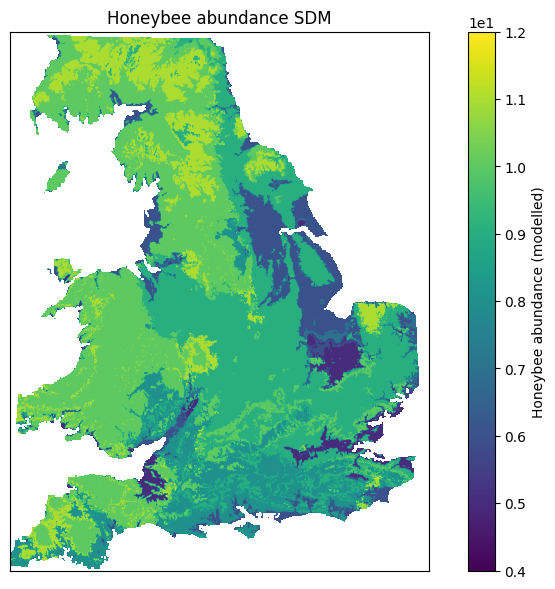

In [66]:
plt.figure(figsize=FIGSIZE)
plt.imshow(bee_abundance_sdm, 
           extent = [ref_bounds.left, ref_bounds.right, ref_bounds.bottom, ref_bounds.top],
          interpolation=None)
plt.title('Honeybee abundance SDM')
plt.xticks([])
plt.yticks([])
plt.colorbar(label='Honeybee abundance (modelled)')
plt.show()

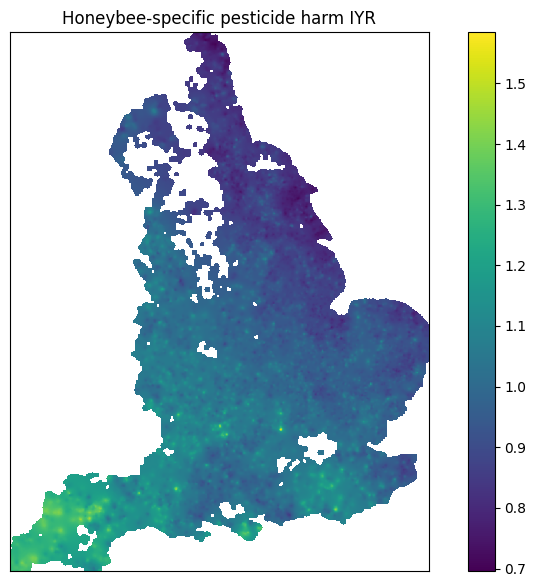

In [70]:
plt.figure(figsize=FIGSIZE)
plt.imshow(iyr_bees_aligned, 
           extent = [ref_bounds.left, ref_bounds.right, ref_bounds.bottom, ref_bounds.top],
          interpolation=None)
plt.title('Honeybee-specific pesticide harm IYR')
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

In [72]:
def rescale_0_1(array):
    max_val = np.nanmax(array)
    min_val = np.nanmin(array)

    result = (array - min_val) / (max_val - min_val)

    return result

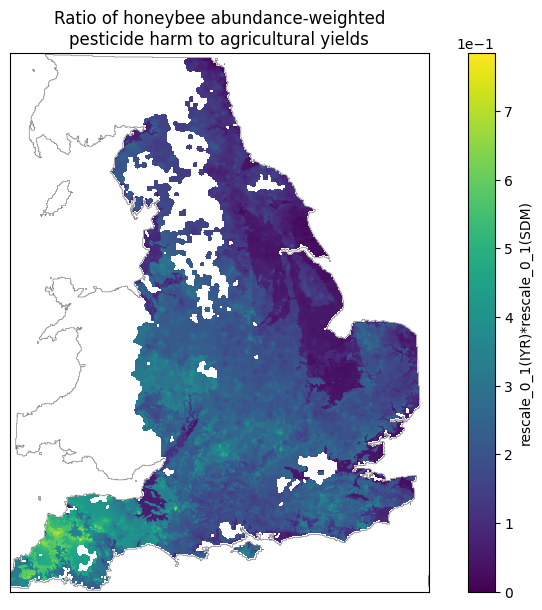

In [86]:
fig, ax = plt.subplots(figsize=FIGSIZE)
im = ax.imshow(rescale_0_1(iyr_bees_aligned)*rescale_0_1(bee_abundance_sdm), 
           extent = [ref_bounds.left, ref_bounds.right, ref_bounds.bottom, ref_bounds.top],
         interpolation=None)

plt.colorbar(im, label='rescale_0_1(IYR)*rescale_0_1(SDM)')
with rasterio.open(bio_var_paths[0]) as file:
    test = gpd.GeoDataFrame.from_features(rasterio.features.dataset_features(file, as_mask=True, geographic=False, band=False), crs=file.crs)

test.geometry.exterior.plot(ax=ax, color='gray', linewidth=0.5)

plt.xticks([])
plt.yticks([])
plt.title('Ratio of honeybee abundance-weighted\npesticide harm to agricultural yields')

plt.show()


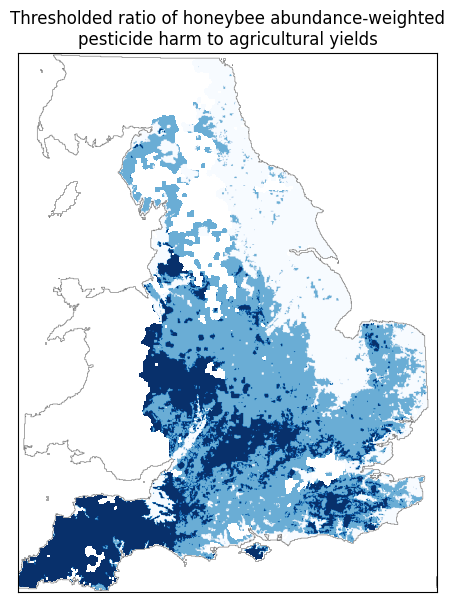

In [91]:
fig, ax = plt.subplots(figsize=FIGSIZE)
scaled = np.digitize(rescale_0_1(iyr_bees_aligned)*rescale_0_1(bee_abundance_sdm), [0, 0.15, 0.25, 1])

im = ax.imshow(np.where(np.isnan(iyr_bees_aligned*bee_abundance_sdm), np.nan, scaled), 
           extent = [ref_bounds.left, ref_bounds.right, ref_bounds.bottom, ref_bounds.top],
         interpolation=None,
         cmap='Blues')

with rasterio.open(bio_var_paths[0]) as file:
    test = gpd.GeoDataFrame.from_features(rasterio.features.dataset_features(file, as_mask=True, geographic=False, band=False), crs=file.crs)

test.geometry.exterior.plot(ax=ax, color='gray', linewidth=0.5)
plt.xticks([])
plt.yticks([])
plt.title('Thresholded ratio of honeybee abundance-weighted\npesticide harm to agricultural yields')

plt.show()


## Discussion and conclusions

This notebook presents three main datasets: an abundance-based honeybee SDM, and IYR map specific to honeybee pesticide harm, and a composite of those two layers that integrates the concept of honeybee abundance into the IYR distribution. The latter can capture the tradeoff between agricultural yield, pesticide use, and harm to biodiversity (here specifically honeybees), at large- and small-scale resolutions.

The honeybee abundance SDM shows higher values in the North and West of the country at the national scale, with more complex spatial patterns at smaller scales. The IYR is particularly high in the South West, with high values also observed in the Midlands and south of London. The combined maps (the last two figures in the results section) reflect the large-scale spatial patterns observed in the individual SDM and IYR maps, identifying the South West as a focus region, along with Midlands (south and west of Birmingham), the Cotswolds, and south of London.

The final figure in the results section presents an arbitrarily thresholded map of the ratio of honeybee abundance-weighted pesticide harm to agricultural yields. Whilst the scaling and discretization of such a metric is dependent on the use case, this map shows how such a dataset may be used to split a region into high, medium and low priority intervention zones. 

Further work related to this topic could include:
- Performing a similar analysis with raw pesticide input data, instead of input to yield ratios, with the aim of identifying areas in which pesticide use poses a high-risk to pollinators regardless of the agricultural yield and comparing against the results presented here.
- Investigating the application of IYR maps for different crops (here the IYR maps were built on winter wheat data).
- Expanding the list of covariates in the pollinator SDM, to potentially include land use and agricultural management factors, and comparing the resulting models against simpler SDMs (such as that presented here)


## References

1. Siviter H, Linguadoca A, Ippolito A, Muth F. Pesticide licensing in the EU and protecting pollinators. Curr Biol. 2023; 33(2): R44-R48. doi: 10.1016/j.cub.2022.12.002.
2. Gallai N, Salles JM, Settele J, Vaissière BE. Economic Valuation of the Vulnerability of World Agriculture Confronted with Pollinator Decline. Ecological Economics. 2009; 68(3): 810-821. https://doi.org/10.1016/j.ecolecon.2008.06.014
3. Ulyshen M, Horn S. Declines of Bees and Butterflies Over 15 Years in a Forested Landscape. Current Biology. 2023; 33(7): 1346-1350.e3. https://doi.org/10.1016/j.cub.2023.02.030.
4. Aizen MA, Aguiar S, Biesmeijer JC, et al. Global Agricultural Productivity Is Threatened by Increasing Pollinator Dependence Without a Parallel Increase in Crop Diversification. Glob Change Biol. 2019; 25: 3516–3527. https://doi.org/10.1111/gcb.14736.
5. UK Pollinator Monitoring Scheme (2022). Flower-insect timed count data from the UK Pollinator Monitoring Scheme, 2017-2020 version 2 NERC EDS Environmental Information Data Centre.
6. Waldock C, Stuart-Smith RD, Albouy C, Cheung WWL, Edgar GJ, Mouillot D, Tjiputra J and Pellissier L. A Quantitative Review of Abundance-Based Species Distribution Models. Ecography. 2022. 2022(1). https://doi.org/10.1111/ecog.05694.
7. Fick SE and Hijmans RJ. WorldClim 2: New 1-Km Spatial Resolution Climate Surfaces for Global Land Areas. Int. J. Climatol. 2017; 37(12); 4302-4315. https://doi.org/10.1002/joc.5086.
8. Fincham WNW, Risser HA, Jarvis SG, Schultz C, Spurgeon DJ, Redhead JW, Storkey J, Pywell RF, Bullock JM. Input to Yield Ratio (IYR) Maps for Wheat Farming in England. 2010-2017 NERC EDS Environmental Information Data Centre. https://doi.org/10.5285/dfe2a4a5-2b3a-4731-ba7f-aea7e926f1dd.
9. Fincham WNW, Risser HA, Jarvis SG, Schultz C, Spurgeon DJ, Redhead JW, Storkey J, Pywell RF, Bullock JM. Mapping the Ratio of Agricultural Inputs to Yields Reveals Areas with Potentially Less Sustainable Farming. Science of the Total Environment. 2024; 909():. https://doi.org/10.1016/j.scitotenv.2023.168491.
